In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import stx
import utils as ut

In [43]:
# Start by loading the data

cnt_pth ="../data/example/Allen1-count-matrix.tsv.gz" # count data
img_pth = "../data/example/Allen1/spatial/tissue_hires_image.png" # HE-image
jsn_pth = "../data/example/Allen1/spatial/scalefactors_json.json" #json file with additional info


# For ease of usage an STdata class has
# been implemented, providing the some
# basic features for data handling

data = stx.STdata(cnt = cnt_pth,
                  img = img_pth,
                  scf = jsn_pth,
                  )

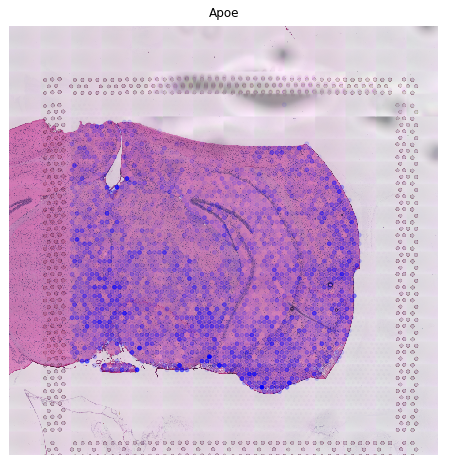

In [53]:
# Our Visium section looks as follows
data.plot(figsize = (8,8))
plt.show()

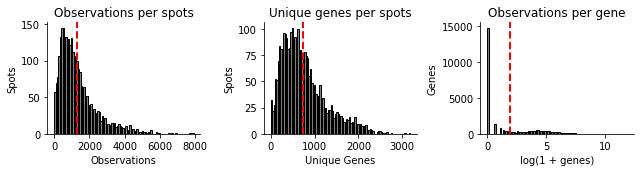

In [44]:
# We can inspect some basic quality metrics

fig, ax = plt.subplots(1,3, figsize = (9,2.5))

# plot number of observed transcripts per spot
stx.obs_per_spot(data.cnt,
                 ax = ax[0])

# plot number of unique genes per spot
stx.unique_genes_per_spot(data.cnt,
                          ax = ax[1])

# plot number of transcripts per gene
stx.obs_per_gene(data.cnt,
                 ax = ax[2])

fig.tight_layout()

In [6]:
# The top highest expressed genes are:

# get top 10 highest expressed
top10 = stx.topNgenes(data.cnt)
#print results in fancy mode
ut.fancy_print(top10)

,Rank,SumTotal,Mean
Bc1,1,136872,45.684913
mt-Co3,2,100440,33.524700
mt-Co1,3,81506,27.204940
mt-Co2,4,65432,21.839786
mt-Atp6,5,62216,20.766355
mt-Cytb,6,50642,16.903204
Fth1,7,38433,12.828104
mt-Nd4,8,34126,11.390521
mt-Nd2,9,25741,8.591789
mt-Nd1,10,25661,8.565087


In [45]:
# There's a high presence of mithocondrial genes
# Using regex we can filter these.
# We will also fitler ribosomal proteins, whilst at it

# define pattern for genes to remove
pattern = '^(Rp)|^(mt)'
# filter data
data.filter_genes(pattern)
# get top 10 most expressed, post filtration
top10 = stx.topNgenes(data.cnt)
# print fancy
ut.fancy_print(top10)

,Rank,SumTotal,Mean
Bc1,1,136872,45.684913
Fth1,2,38433,12.828104
Tmsb4x,3,18680,6.234980
Cst3,4,17885,5.969626
Gapdh,5,16355,5.458945
Ppia,6,16258,5.426569
Cox4i1,7,12821,4.279372
Ubb,8,11976,3.997330
Cox6c,9,11128,3.714286
Ndufa4,10,10488,3.500668


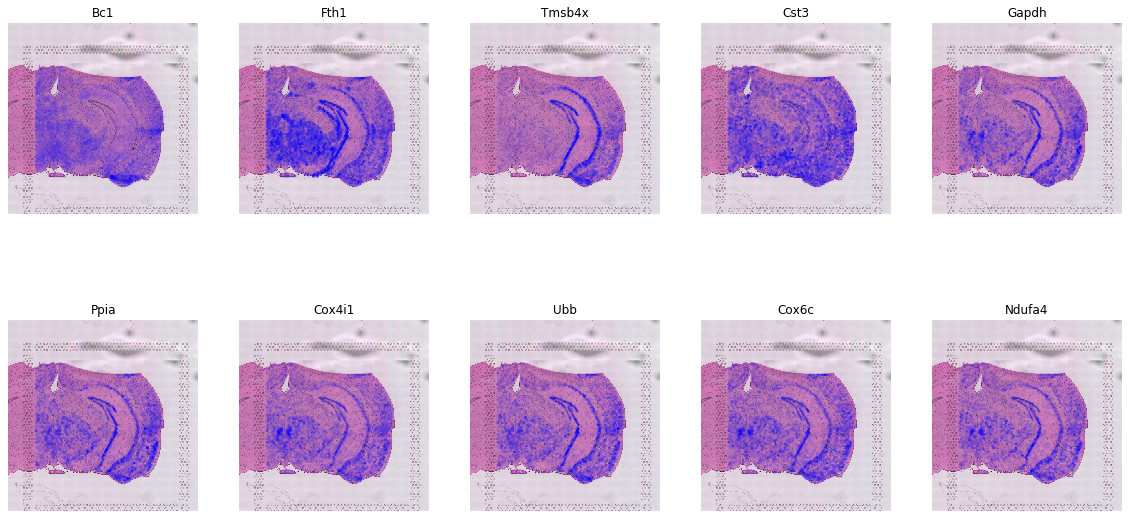

In [46]:
# Next we'll visualize these
# top 10 most expressed genes

fig,ax = plt.subplots(2,5,figsize = (20,10))
ax = ax.flatten()

# to visualize the gene expression of each gene
# we'll update the feature of interest (foi)
# and then use the plot method of the STdata class

for k,gene in enumerate(top10.index.values):
    data.set_foi(gene) 
    data.plot(marker_size = 3,
              fig = fig,
              ax = ax[k]) 

<IPython.core.display.Javascript object>


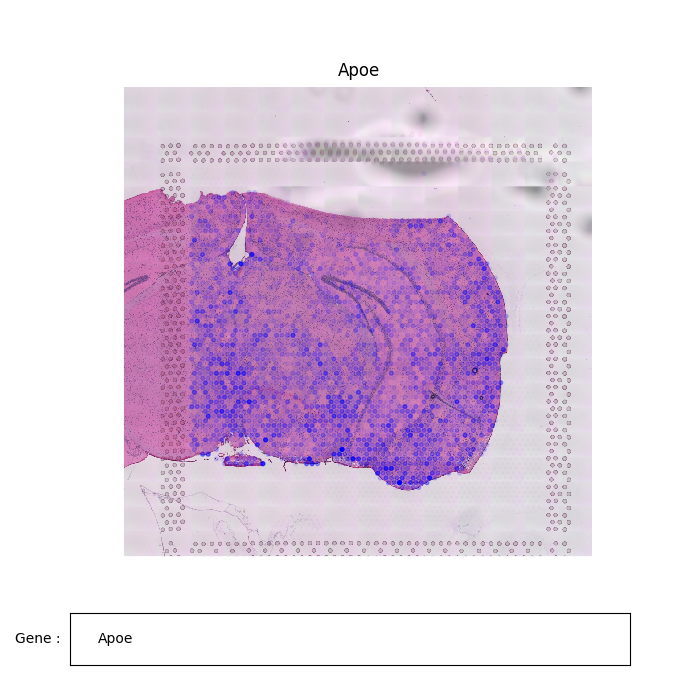

In [51]:
# We could also inspect any gene of our choice in
# a more interactive way. Allowing us to probe for

%matplotlib notebook

from matplotlib.widgets import TextBox

# Initialize Interactive plot
initial_text = "Apoe"

data.set_foi(initial_text)

ifig, iax = plt.subplots(1,1,
                         figsize=(7,7))

data.plot(marker_size = 8,
          ax = iax,
          fig = ifig)

# define action on submission
def submit(text):
    if not isinstance(text,str):
        print("[ERROR] : Enter gene name")
    else:
        data.set_foi(text)
        iax.clear()
        data.plot(marker_size = 10,
                  ax = iax,
                  fig = ifig)
        plt.draw()
        
# add text box for gene input
axbox = plt.axes([0.1, 0.05, 0.8, 0.075])
plt.subplots_adjust(bottom=0.2)

text_box = TextBox(axbox,
                   'Gene : ',
                   initial=initial_text,)

text_box.on_submit(submit)
# plot
plt.show()

In [52]:
%matplotlib inline

# For an initial quick analysis we could also
# cluster the expression data. 

np.random.seed(1337)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
import umap

n_clusters = 12

dimred = FastICA(n_components = 20)
km = KMeans(n_clusters = n_clusters)

# First we normalize the data
ncnt = stx.normalize_cnt(data.cnt)
# Project data to a 20 dim space
ncnt = dimred.fit_transform(ncnt)
# Cluster the data
cidx = km.fit_predict(ncnt)
# Project into 2 dim space for visualization
umap_crd = umap.UMAP().fit_transform(ncnt)


/home/alma/.local/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


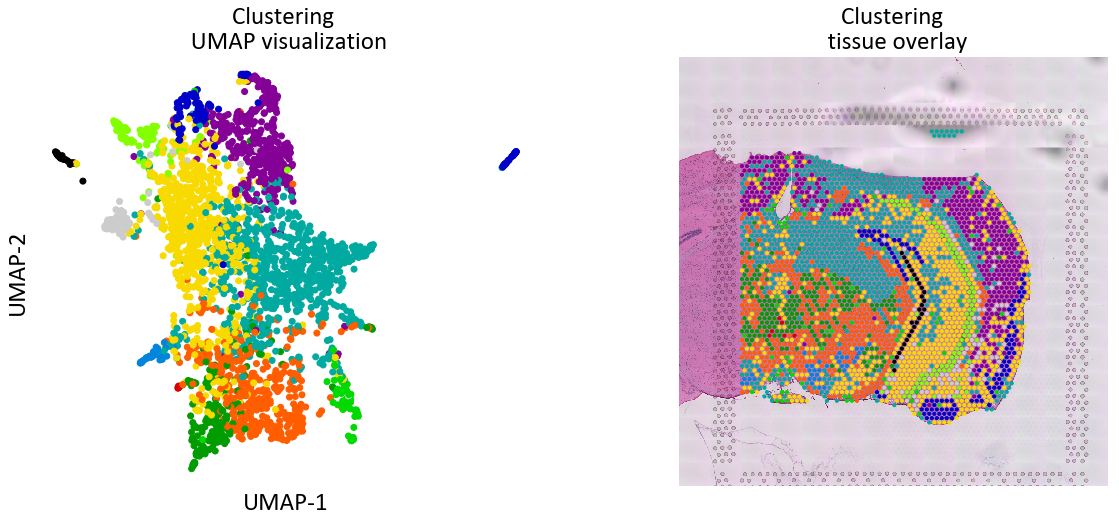

In [54]:
# We can plot our results

# Set plot specs
cmap = plt.cm.nipy_spectral
data.set_foi(cidx)
style_dict = {'fontsize':25,
              'fontfamily':'Calibri'}


fig, ax = plt.subplots(1,2,
                       figsize = (20,8))

# Visualize clusters in reduced space
ax[0].scatter(umap_crd[:,0],
              umap_crd[:,1],
              c = cidx,
              cmap = cmap)

# clean up plot
ut.clean_spines(ax[0],)
ut.clean_ticks(ax[0])

# label plot
ax[0].set_title("Clustering \n UMAP visualization",
                **style_dict)
ax[0].set_xlabel("UMAP-1",**style_dict)
ax[0].set_ylabel("UMAP-2",**style_dict)


# Visualize clusters on tissue
_,ax[1] = data.plot(marker_size = 10, 
                   cmap = cmap,
                   ax = ax[1],
                   fig = fig)

ax[1].set_title("Clustering \n tissue overlay",
                **style_dict)

plt.show()


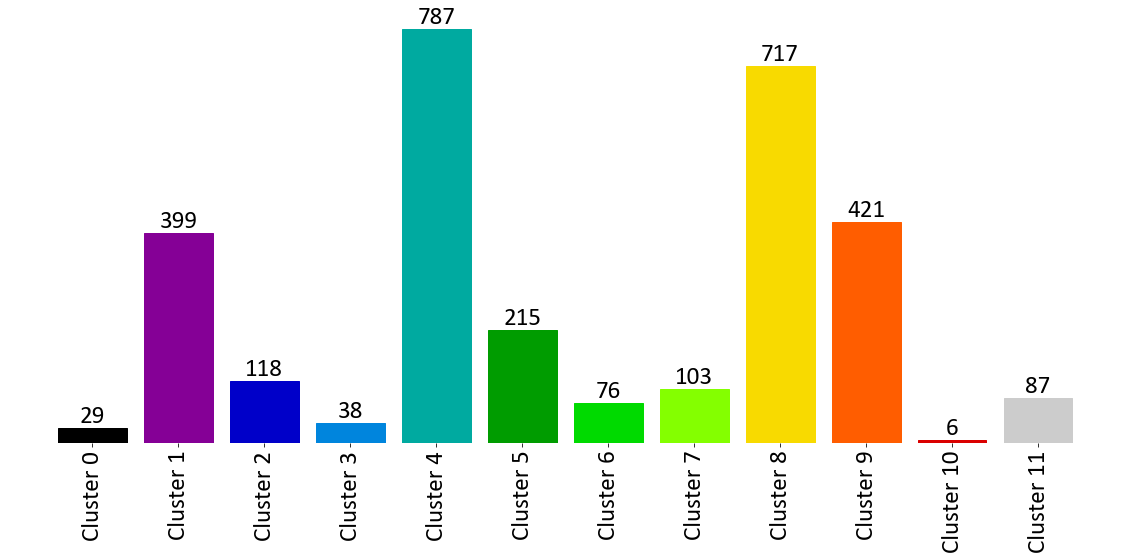

In [55]:
# The distribution of our clusters looks as follows

fig, ax = ut.plot_member_distribution(cidx,
                                      cmap = cmap,
                                      style_dict  = style_dict)

plt.show()

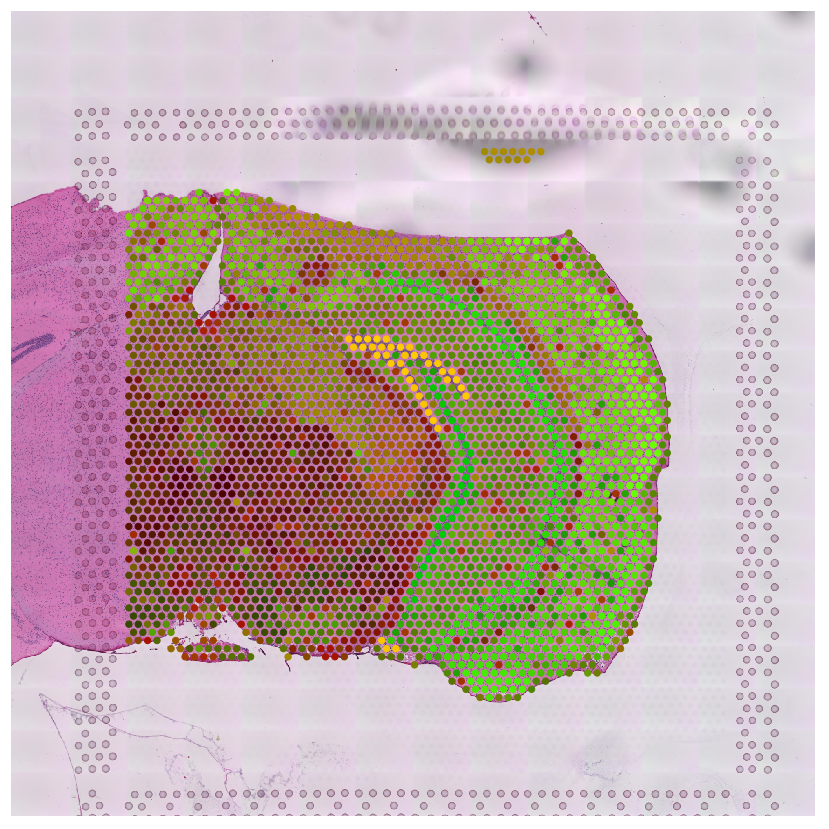

In [56]:
# For a smoother visualization we
# could use the UMAP projections
# to color our spots

# Map UMAP projections to unit square
rgb = np.zeros((data.S,3))
mn = umap_crd.min(axis=0).reshape(1,-1)
mx = umap_crd.max(axis=0).reshape(1,-1)
rgb[:,0:2] = (umap_crd  - mn) / (mx - mn)
# set feature of interest
data.set_foi(rgb)
# plot
fig, ax = data.plot(marker_size = 40,
                     figsize = (15,15))